## Setup

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy.signal import savgol_filter
import random

# mapping '/' to __truediv__()
from __future__ import division 

from sklearn.metrics import mean_absolute_error
# possible alternative to above:
# tf.metrics.MeanAbsoluteError()

# helper code
from WindowGenerator import WindowGenerator
from Baseline import Baseline
from ModelGenerator import ModelGenerator

mpl.rcParams['figure.figsize'] = (12, 3)
mpl.rcParams['axes.grid'] = False

VERBOSE = True
MAX_EPOCHS = 30
INPUT_WIDTH = 3
SHIFT = 8
LABEL_WIDTH = 1
WINDOW_SIZE = INPUT_WIDTH + SHIFT

if VERBOSE:
    print('Setup Complete')

Setup Complete


## Import, Process, Graph

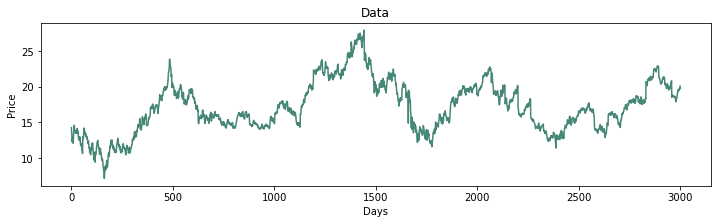

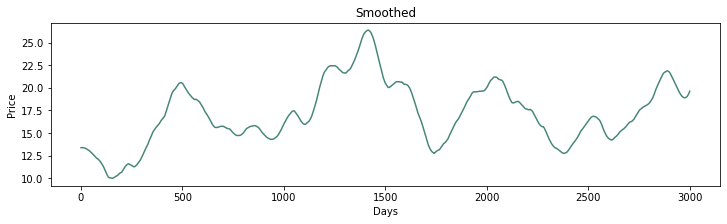

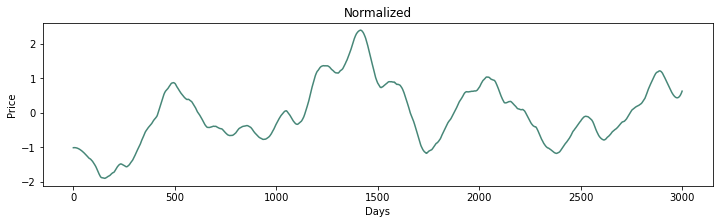

0      2002-02-15
1      2002-02-19
2      2002-02-20
3      2002-02-21
4      2002-02-22
          ...    
2995   2014-01-09
2996   2014-01-10
2997   2014-01-13
2998   2014-01-14
2999   2014-01-15
Name: ds, Length: 3000, dtype: datetime64[ns]
total samples = 3000
----------------------------------------
train_df samples = 2100
val_df samples = 600
test_df samples = 300
----------------------------------------
train + val + test = 3000


In [65]:
df = pd.read_csv('data/csco_edit.csv')
# print(df)

# throw out some data
start = 3000 # 0
end = 6000 # len(df['y'])
df_len = len(df['y'])
df = df.drop(index=range(0, start))
# print(df)
df = df.drop(index=range(end, df_len))
# print(df)
df = df.set_index(np.arange(0, len(df['y'])))
# print(df)

# seperate date_time
date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
# timestamp doesn't work if data is before 1970
if (date_time[0].year >= 1970):
    timestamp_s = date_time.map(datetime.datetime.timestamp)

plt.title('Data')
y = df['y']
x = np.arange( 0, len(y), 1 )
plt.ylabel('Price')
p1, = plt.plot( x, y, color='#478778' )
plt.xlabel('Days')
plt.show()

# smooth data
df['y'] = savgol_filter(df['y'], 155, 3) # window size, polynomial order

plt.title('Smoothed')
y = df['y']
x = np.arange( 0, len(y), 1 )
plt.ylabel('Price')
p1, = plt.plot( x, y, color='#478778' )
plt.xlabel('Days')
plt.show()

# split
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# normalize
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

plt.title('Normalized')
df_std = (df - train_mean) / train_std
y = df_std['y']
x = np.arange( 0, len(y), 1 )
plt.ylabel('Price')
p1, = plt.plot( x, y, color='#478778' )
plt.xlabel('Days')
plt.show()

if VERBOSE:
    print( date_time )
    print( "total samples = {0:d}".format( n ) )
    print( "----------------------------------------" )
    print( "train_df samples = {0:d}".format( len( train_df ) ) )
    print( "val_df samples = {0:d}".format( len( val_df ) ) )
    print( "test_df samples = {0:d}".format( len( test_df ) ) )
    print( "----------------------------------------" )
    print( "train + val + test = {0:d}".format( len( train_df ) + len( val_df ) + len( test_df ) ) )

## Frequency

frequencies: 1001
years: 7.968127490039841


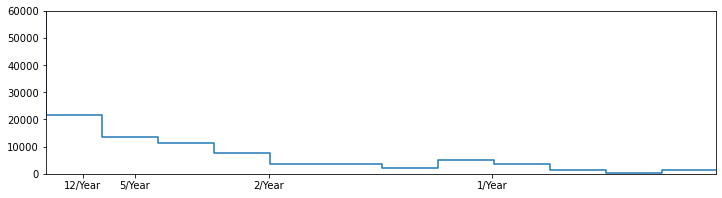

In [89]:
fft = tf.signal.rfft(df['y'])

# range for ibm: [10000:12000]

f_per_dataset = np.arange(0, len(fft))
n_samples_d = len(df['y'])
busi_days_per_year = 251 # less than business days but close to correct # of years
years_per_dataset = n_samples_d/(busi_days_per_year)
f_per_year = f_per_dataset/years_per_dataset

if VERBOSE:
    print(f'frequencies: {len(fft)}') # data_length / 2 + 1
    print(f'years: {years_per_dataset}')
    # print(f_per_year)

plt.step(f_per_year, np.abs(fft))
plt.ylim(0, 60000)
plt.xlim([0.001, 1.5])
plt.xticks([0.083, 0.2, 0.5, 1], labels=['12/Year', '5/Year', '2/Year', '1/Year']) # f = 1/#years
plt.show()

## Make Model and Compile

In [92]:
model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                            input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, 
                            shift=SHIFT, max_epochs=MAX_EPOCHS, label_columns=['y'])
if VERBOSE:
    print(model.conv_window)

Total window size: 11
Input indices: [0 1 2]
Label indices: [10]
Label column name(s): ['y']


mean absolute error (test): 0.094
adjusted mae (test): 13.815


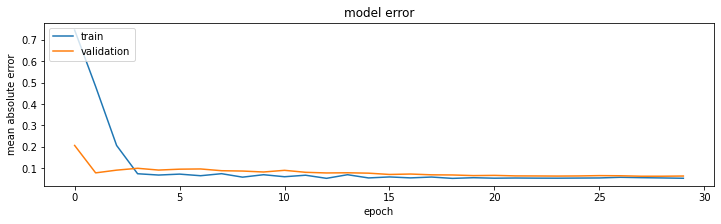

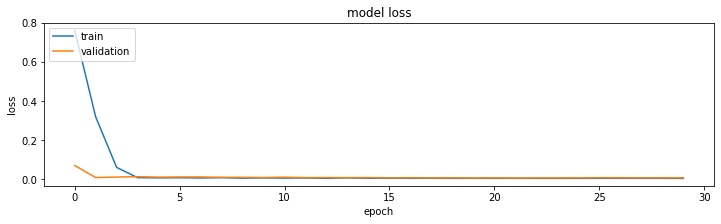

In [93]:
# train and eval model
history = model.compile_and_fit()
IPython.display.clear_output()

# use model on test
y, y_p, mae = model.test_model()
print( "mean absolute error (test): {0:0.3f}".format( mae ) )
print(f'adjusted mae (test): {round(float(mae*train_mean), 3)}')

plt.title('model error')
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.title('model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Test Results

mean absolute error (test): 0.094
adjusted mae (test): 13.815


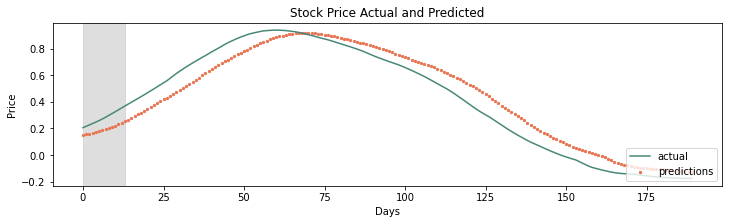

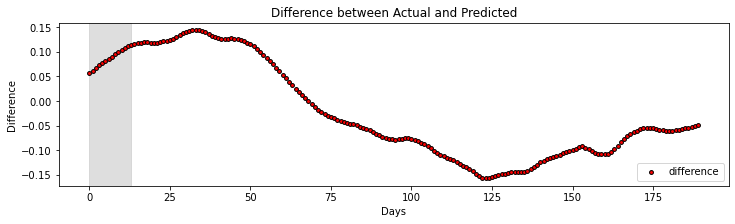

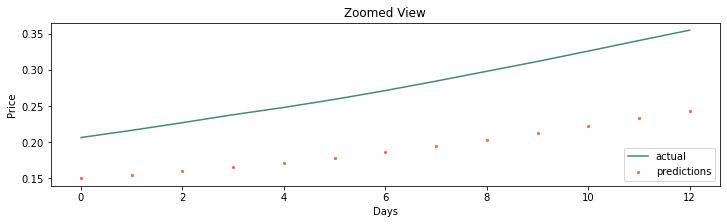

In [94]:
print( "mean absolute error (test): {0:0.3f}".format( mae ) )
print(f'adjusted mae (test): {round(float(mae*train_mean), 3)}')

x = np.arange( 0, len(y), 1 )
zoom_pwr = 14
zoom_idx = int(np.floor(len(y)/zoom_pwr))
x_zoom = np.arange(0, zoom_idx, 1)
y_zoom = y[: zoom_idx]
y_p_zoom = y_p[: zoom_idx]
shd_alpha = 0.6

plt.title('Stock Price Actual and Predicted')
plt.ylabel('Price')
plt.axvspan(0, zoom_idx, alpha=shd_alpha, color='#C9C9C9', zorder=0)
p1, = plt.plot( x, y, label='test', color='#478778' )
p2 = plt.scatter( x, y_p, edgecolors='#E97451', color='#E97451', s=5 )
plt.legend(handles=[p1, p2], labels=['actual', 'predictions'], loc='lower right')
plt.xlabel('Days')
plt.show()

plt.title('Difference between Actual and Predicted')
plt.ylabel('Difference')
p1 = plt.scatter( x, ( y-y_p ), edgecolors='black', color='red', s=15 )
plt.axvspan(0, zoom_idx, alpha=shd_alpha, color='#C9C9C9', zorder=0)
plt.legend(handles=[p1], labels=['difference'], loc='lower right')
plt.xlabel('Days')
plt.show()

plt.title('Zoomed View')
plt.ylabel('Price')
plt.plot( x_zoom, y_zoom, label='test', color='#478778' )
plt.scatter( x_zoom, y_p_zoom, edgecolors='#E97451', color='#E97451', s=5)
plt.legend(['actual', 'predictions'], loc='lower right')
plt.xlabel('Days')
plt.show()

## Real World Test
Make a single prediction based on the history of a different stock.

              ds        y
9573  2000-01-12  40.5560
9574  2000-01-13  41.0880
9575  2000-01-14  40.5810
9576  2000-01-18  39.5460
9577  2000-01-19  39.6760
9578  2000-01-20  38.9955
9579  2000-01-21  38.9700
9580  2000-01-24  37.6910
9581  2000-01-25  37.0335
9582  2000-01-26  37.5100
9583  2000-01-27  37.2125

Prediction:        35.8771


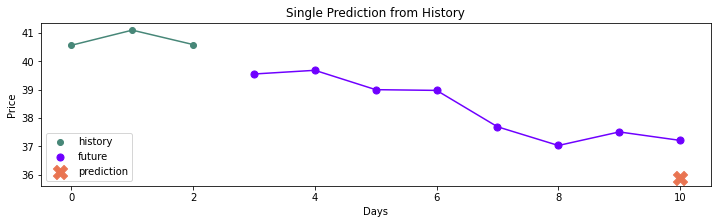

In [104]:
# specify pathname
pathname = 'data/ge_edit.csv'
df = pd.read_csv(pathname)
df_len = len(df['y'])

# adjust start_idx to pick a different range of values
start_idx = random.randint(0,len(df['y'])-WINDOW_SIZE)

start_idx = min(start_idx, len(df['y'])-WINDOW_SIZE)
start_idx = max(start_idx, 0)
# drop beginning
df = df.drop(index=range(0, start_idx))
# drop end
df = df.drop(index=range(start_idx+WINDOW_SIZE, df_len))

print(df)

# seperates date_time from df
date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
# timestamp_s = date_time.map(datetime.datetime.timestamp)

# divide dataframe
input_df = df[:INPUT_WIDTH]
future_df = df[INPUT_WIDTH:] # pretend we don't know these future values

# make prediction
y_p = model.single_window(df)

# history
y = input_df.to_numpy()
x = np.arange(0, len(y), 1)
# future
y_f = future_df.to_numpy()
x_f = np.arange(len(y), len(y) + len(y_f), 1)
# prediction
y_p = np.array( y_p )
x_p = WINDOW_SIZE-1

if VERBOSE:
    y_p_format = "{:.4f}".format(y_p[0])
    print(f"\nPrediction:        {y_p_format}")

# plot
plt.title('Single Prediction from History')
plt.ylabel('Price')
s1 = plt.scatter(x, y, edgecolors='#478778', color='#478778')
plt.plot(x, y, color='#478778')
s2 = plt.scatter(x_f, y_f, edgecolors='#6F00FF', color='#6F00FF', s=50)
plt.plot(x_f, y_f, color='#6F00FF')
s3 = plt.scatter(x_p, y_p, edgecolors='#E97451', color='#E97451', s=200, marker='X', zorder=10)
plt.legend(handles=[s1, s2, s3], labels=['history', 'future', 'prediction'], loc='lower left')
plt.xlabel('Days')
plt.show()

## Window Testing Loop
Test different window configs and record results.

In [ ]:
results = pd.DataFrame(index=range(0,14+1), columns=range(1,14+1))
grid = []

for shift_idx in range(0,14+1):
    row = []
    for input_width_idx in range(1,14+1):
        model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                            input_width=input_width_idx, label_width=LABEL_WIDTH, 
                            shift=shift_idx, max_epochs=MAX_EPOCHS, label_columns=['y'])
        history = model.compile_and_fit()
        IPython.display.clear_output()
        y, y_p, mae = model.test_model()
        mae = mae*train_mean
        row.append(mae)
    grid.append(row)
grid = np.array(grid)
np.save('data/perf_grid.npy', grid)
if VERBOSE:
    print('Done!')
# print(grid)

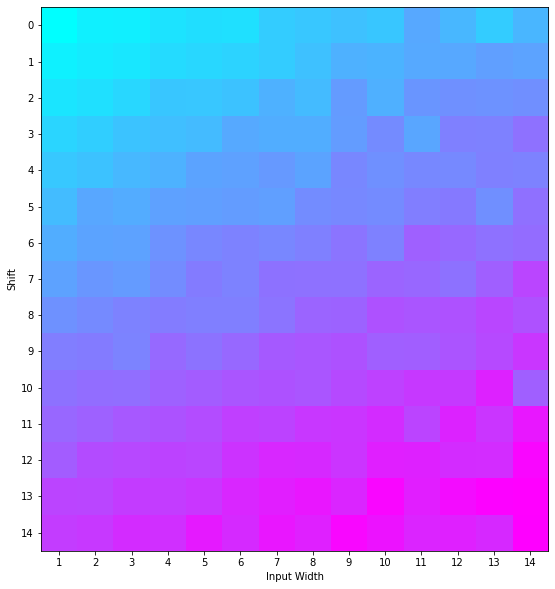

In [20]:
# load grid from drive
grid = np.load('data/perf_grid.npy')

plt.figure(figsize=(10,10))
plt.imshow(grid, cmap='cool', interpolation='nearest')
plt.yticks(range(0,14+1), range(0,14+1))
plt.xticks(range(0,13+1), range(1,14+1))
plt.xlabel('Input Width')
plt.ylabel('Shift')
plt.show()

## Chunks
Use data in chunks of 1k or 2k.

In [85]:
df = pd.read_csv('data/ibm_edit.csv')

# seperate date_time
date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
# timestamp doesn't work if data is before 1970
if (date_time[0].year >= 1970):
    timestamp_s = date_time.map(datetime.datetime.timestamp)

# smooth data
df['y'] = savgol_filter(df['y'], 155, 3) # window size, polynomial order

# make chunks
chunk_size = 2000
chunk_size = min(chunk_size, len(df['y']))
chunk_size = max(chunk_size, 1)
df_list = []
for i in range(0, len(df['y']), chunk_size):
    df_temp = df.drop(index=range(0, i))
    df_temp = df_temp.drop(index=range(i+chunk_size, len(df['y'])))
    df_temp = df_temp.set_index(np.arange(0, len(df_temp['y'])))
#     print(df_temp)
    df_list.append(df_temp)
# print(df_list)

# throw out small chunk
if (len(df_list[-1] < chunk_size)):
    df_list.pop(-1)

# ML with chunks
mae_list = []
for df in df_list:
    
    # split
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]
    
    # normalize
    train_mean = train_df.mean()
    train_std = train_df.std()
    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    # compile
    model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                            input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, 
                            shift=SHIFT, max_epochs=MAX_EPOCHS, label_columns=['y'])
    history = model.compile_and_fit()
    IPython.display.clear_output()
    y, y_p, mae = model.test_model()
    mae = mae*train_mean
    mae_list.append(mae)

if VERBOSE:
    print("Done!")

Done!


In [86]:
i = 1
for num in mae_list:
    print(f"mae {i}: {round(num.at['y'], 4)}")
    i = i+1

mae 1: 0.2631
mae 2: 0.2331
mae 3: 1.5819
mae 4: 8.4989
mae 5: 2.8947
mae 6: 14.9791
mae 7: 13.5401
